# Google Drive Interface Setup

In [1]:
from google.colab import drive, auth
import sys

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Pull down github repo, store in colab runtime memory
!git clone https://github.com/andrew-loeber/proj_utils_207.git

Cloning into 'proj_utils_207'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 34 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), 8.70 KiB | 217.00 KiB/s, done.


In [4]:
# Tell Python to also look in this repo when running an import
sys.path.insert(1, "/content/proj_utils_207")

In [5]:
# Authenticate google account and give back the session access token
auth.authenticate_user()
gcloud_token = !gcloud auth print-access-token
gcloud_token

['ya29.a0AbVbY6MPU1841Qvp1N-o1aJQKc2h0A-p1__omrtlnAeUG0-Ef9xPNJRRuUn7XBrIr88dqTM2yfvAj2vGCSMB27aBh2_v4xDkJ0g1d7ZdN_3q5_Pq4l9B1ZFZ4IDGFeg1e3dHKYXzlVFg9pKXXky2N_3ZECrxaCgYKAWYSARASFQFWKvPlOsEoIG2syriBpEAkXiOgcw0163']

In [6]:
from gdriveinterface import GDriveInterface
import proj_ref

In [7]:
# Show email address, username, and the path of the shared project folder on
# your Google Drive instance
gdi = GDriveInterface(gcloud_token)
shared_folder_path = gdi.shared_folder_path
gdi.__dict__

{'email': 'aloeber@berkeley.edu',
 'account': 'aloeber',
 'shared_folder_path': '/content/drive/MyDrive/207-Project'}

In [8]:
# Show name keys and paths for tracked files
proj_ref.files

{'taxonomy': 'BirdCLEF/eBird_Taxonomy_v2021.csv',
 'orig_metadata': 'BirdCLEF/train_metadata_with_duration.csv',
 'sample_metadata': 'data/sample_metadata.csv',
 'species_metadata': 'data/species_metadata.csv',
 'train_metadata': 'data/train_metadata.csv',
 'test_metadata': 'data/test_metadata.csv'}

In [9]:
# Show name keys and paths for tracked directories
proj_ref.dirs

{'orig_audio': {'path': 'BirdCLEF/train_audio'},
 'train_audio': {'path': 'data/train/audio_files'},
 'test_audio': {'path': 'data/test/audio_files'},
 'train_npy_full': {'path': 'data/train/librosa_loaded'},
 'test_npy_full': {'path': 'data/test/librosa_loaded'},
 'train_npy_loud5s': {'path': 'data/train/librosa_loaded_loudest_5sec'},
 'test_npy_loud5s': {'path': 'data/test/librosa_loaded_loudest_5sec'}}

### **Usage examples**

##### Query specific file based on named key
```
command: gdi.get_file_path('taxonomy')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/eBird_Taxonomy_v2021.csv'
```

##### Query specific directory based on named key
```
command: gdi.get_dir_path('orig_audio')
returns: '/content/drive/MyDrive/207-Project/BirdCLEF/train_audio'
```

##### Query specific sample record based on named keys for directory and file
```
command: gdi.get_sample_path('train_audio', 'barswa/XC132406.ogg')
returns: '/content/drive/MyDrive/207-Project/data/train/audio_files/barswa/XC132406.ogg'
```

##### Provide full path given a custom partial path
```
command: gdi.join_to_shared('images/sandpiper.jpeg')
returns: '/content/drive/MyDrive/207-Project/images/sandpiper.jpeg'
```


# Imports and Setup

In [10]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 2.9 MB/s eta 0:00:00


In [11]:
!pip install colorednoise

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers
import librosa
from IPython.display import Audio
import audiomentations as am
import colorednoise as cn
from sklearn.decomposition import NMF

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Read in sample metadata

In [14]:
sample_meta_df = pd.read_csv(gdi.get_file_path('sample_metadata'))
sample_meta_df

primary_label          common_name    scientific_name  species_rank  \
0          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
1          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
2          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
3          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
4          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
...            ...                  ...                ...           ...   
4675       cohmar1  Common House-Martin   Delichon urbicum             9   
4676       cohmar1  Common House-Martin   Delichon urbicum             9   
4677       cohmar1  Common House-Martin   Delichon urbicum             9   
4678       cohmar1  Common House-Martin   Delichon urbicum             9   
4679       cohmar1  Common House-Martin   Delichon urbicum             9   

                  filename dataset  duration_secs  duration_mins  \
0     thrnig1/XC110335.ogg   train     119.275102       1.987918   
1     thrnig1/XC110336.ogg   train     122.044127       2.034069   
2     thrnig1/XC112492.ogg    test      58.540408       0.975673   
3     thrnig1/XC118260.ogg   train      44.382041       0.739701   
4     thrnig1/XC120947.ogg   train     189.231066       3.153851   
...                    ...     ...            ...            ...   
4675  cohmar1/XC749483.ogg   train      20.950249       0.349171   
4676  cohmar1/XC749488.ogg    test      71.915102       1.198585   
4677  cohmar1/XC749637.ogg    test       5.040000       0.084000   
4678  cohmar1/XC749638.ogg   train       6.984036       0.116401   
4679  cohmar1/XC751198.ogg   train      17.266032       0.287767   

      duration_hrs  species_total_files  species_train_files  \
0         0.033132                  499                  349   
1         0.033901                  499                  349   
2         0.016261                  499                  349   
3         0.012328                  499                  349   
4         0.052564                  499                  349   
...            ...                  ...                  ...   
4675      0.005820                  408                  286   
4676      0.019976                  408                  286   
4677      0.001400                  408                  286   
4678      0.001940                  408                  286   
4679      0.004796                  408                  286   

      species_test_files  species_total_duration_hrs  \
0                    150                   17.078735   
1                    150                   17.078735   
2                    150                   17.078735   
3                    150                   17.078735   
4                    150                   17.078735   
...                  ...                         ...   
4675                 122                    5.656965   
4676                 122                    5.656965   
4677                 122                    5.656965   
4678                 122                    5.656965   
4679                 122                    5.656965   

      species_train_duration_hrs  species_test_duration_hrs  total_files  \
0                      10.739077                   6.339658         4680   
1                      10.739077                   6.339658         4680   
2                      10.739077                   6.339658         4680   
3                      10.739077                   6.339658         4680   
4                      10.739077                   6.339658         4680   
...                          ...                        ...          ...   
4675                    4.103189                   1.553775         4680   
4676                    4.103189                   1.553775         4680   
4677                    4.103189                   1.553775         4680   
4678                    4.103189                   1.553775         4680 

In [15]:
train_meta_df = pd.read_csv(gdi.get_file_path('train_metadata'))
train_meta_df

primary_label          common_name    scientific_name  species_rank  \
0          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
1          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
2          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
3          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
4          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
...            ...                  ...                ...           ...   
3273       cohmar1  Common House-Martin   Delichon urbicum             9   
3274       cohmar1  Common House-Martin   Delichon urbicum             9   
3275       cohmar1  Common House-Martin   Delichon urbicum             9   
3276       cohmar1  Common House-Martin   Delichon urbicum             9   
3277       cohmar1  Common House-Martin   Delichon urbicum             9   

                  filename dataset  duration_secs  duration_mins  \
0     thrnig1/XC110335.ogg   train     119.275102       1.987918   
1     thrnig1/XC110336.ogg   train     122.044127       2.034069   
2     thrnig1/XC118260.ogg   train      44.382041       0.739701   
3     thrnig1/XC120947.ogg   train     189.231066       3.153851   
4     thrnig1/XC125024.ogg   train      45.312018       0.755200   
...                    ...     ...            ...            ...   
3273  cohmar1/XC748724.ogg   train      54.909025       0.915150   
3274  cohmar1/XC748726.ogg   train       6.974694       0.116245   
3275  cohmar1/XC749483.ogg   train      20.950249       0.349171   
3276  cohmar1/XC749638.ogg   train       6.984036       0.116401   
3277  cohmar1/XC751198.ogg   train      17.266032       0.287767   

      duration_hrs  species_total_files  species_train_files  \
0         0.033132                  499                  349   
1         0.033901                  499                  349   
2         0.012328                  499                  349   
3         0.052564                  499                  349   
4         0.012587                  499                  349   
...            ...                  ...                  ...   
3273      0.015253                  408                  286   
3274      0.001937                  408                  286   
3275      0.005820                  408                  286   
3276      0.001940                  408                  286   
3277      0.004796                  408                  286   

      species_test_files  species_total_duration_hrs  \
0                    150                   17.078735   
1                    150                   17.078735   
2                    150                   17.078735   
3                    150                   17.078735   
4                    150                   17.078735   
...                  ...                         ...   
3273                 122                    5.656965   
3274                 122                    5.656965   
3275                 122                    5.656965   
3276                 122                    5.656965   
3277                 122                    5.656965   

      species_train_duration_hrs  species_test_duration_hrs  total_files  \
0                      10.739077                   6.339658         4680   
1                      10.739077                   6.339658         4680   
2                      10.739077                   6.339658         4680   
3                      10.739077                   6.339658         4680   
4                      10.739077                   6.339658         4680   
...                          ...                        ...          ...   
3273                    4.103189                   1.553775         4680   
3274                    4.103189                   1.553775         4680   
3275                    4.103189                   1.553775         4680   
3276                    4.103189                   1.553775         4680 

# Define helper functions

In [16]:
def load_random_clip(
    file_path
    , file_duration
    , clip_secs=5.0
  ):

  offset = np.random.uniform(low=0.0, high=file_duration - clip_secs)
  audio, sr = librosa.load(
    path=file_path
    , sr=None
    , offset=offset
    , duration=clip_secs
    , dtype=np.float32
  )
  return audio, sr, (offset, offset + clip_secs)


def load_resampled_random_clip(
    file_path
    , file_duration
    , clip_secs=5.0
    , target_sr=16000
  ):

  offset = np.random.uniform(low=0.0, high=file_duration - clip_secs)
  audio, sr = librosa.load(
    path=file_path
    , sr=target_sr
    , offset=offset
    , duration=clip_secs
    , dtype=np.float32
  )
  return audio, sr, (offset, offset + clip_secs)

In [17]:
def audio_compress(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_compress(samples, mu=mu, quantize=False)

def audio_expand(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_expand(samples, mu=mu, quantize=False)

def add_silent_frames(samples, sample_rate, p_min=5e-5, p_max=5e-2):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=1-prob, size=len(samples))
  return mask * samples

def add_crackle(samples, sample_rate, p_min=1e-6, p_max=2e-4):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=prob, size=len(samples))
  noise = np.random.binomial(n=1, p=0.5, size=len(samples)) * 2 - 1
  return np.where(mask, noise, samples)

def add_colored_noise(
    samples
    , sample_rate
    , exp_min=-4
    , exp_max=2
    , scale_min=0.005
    , scale_max=0.025
    ):
  exp = np.random.uniform(low=exp_min, high=exp_max)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = cn.powerlaw_psd_gaussian(exp, size=len(samples))
  return samples + (scale * noise)

def add_colored_noise2(
    samples
    , sample_rate
    , min_gain_db=-18.0
    , max_gain_db=18.0
    , scale_min=0.005
    , scale_max=0.05
    ):
  eq = am.SevenBandParametricEQ(
      min_gain_db=min_gain_db
      , max_gain_db=max_gain_db
      , p=1.0
  )
  norm = am.Normalize(p=1.0)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = np.random.randn(len(samples))
  noise = eq(noise, sample_rate=sample_rate)
  noise = norm(noise, sample_rate=sample_rate)
  return samples + (scale * noise)

# Exploration

In [ ]:
noise = 0.5 * cn.powerlaw_psd_gaussian(-5, 100000) + cn.powerlaw_psd_gaussian(1.25, 100000)
Audio(noise, rate=32000, autoplay=True)

In [ ]:
noise.shape

(100000,)

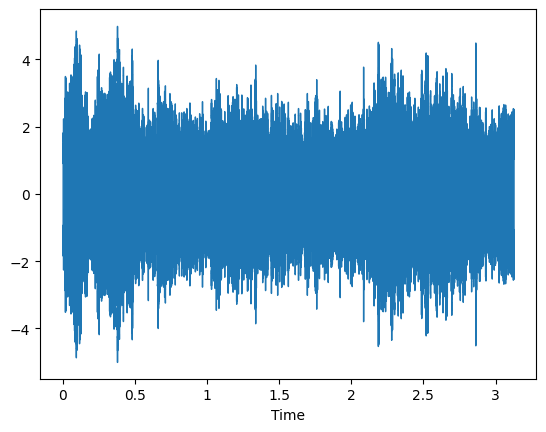

In [ ]:
librosa.display.waveshow(noise, sr=32000)

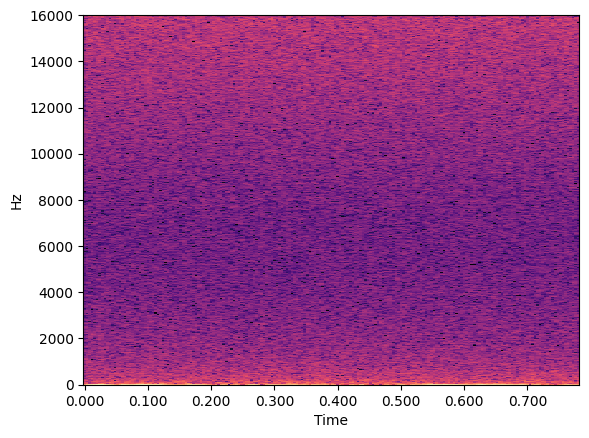

In [ ]:
S = np.abs(librosa.stft(noise, n_fft=2048, hop_length=512))
S_db = librosa.amplitude_to_db(S, ref=np.max)
librosa.display.specshow(
    S_db
    , x_axis='time'
    , y_axis='linear'
    , sr=32000
    , hop_length=128
)

In [16]:
def load_random_clip(
    file_path
    , file_duration
    , clip_secs=5.0
  ):

  offset = np.random.uniform(low=0.0, high=file_duration - clip_secs)
  audio, sr = librosa.load(
    path=file_path
    , sr=None
    , offset=offset
    , duration=clip_secs
    , dtype=np.float32
  )
  return audio, sr, (offset, offset + clip_secs)


def load_resampled_random_clip(
    file_path
    , file_duration
    , clip_secs=5.0
    , target_sr=16000
  ):

  offset = np.random.uniform(low=0.0, high=file_duration - clip_secs)
  audio, sr = librosa.load(
    path=file_path
    , sr=target_sr
    , offset=offset
    , duration=clip_secs
    , dtype=np.float32
  )
  return audio, sr, (offset, offset + clip_secs)


In [ ]:
file_path = gdi.get_sample_path('train_audio', 'cohmar1/XC749483.ogg')
file_path

'/content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC749483.ogg'

In [ ]:
audio_clip, sr, segment = load_resampled_random_clip(
    file_path
    , sample_meta_df.iloc[4675]['duration_secs']
    , 5.0
)

In [ ]:
Audio(data=audio_clip, rate=sr, autoplay=True)

In [24]:
def audio_compress(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_compress(samples, mu=mu, quantize=False)

def audio_expand(samples, sample_rate, mu_min=1, mu_max=17):
  mu = np.random.uniform(low=mu_min, high=mu_max)
  return librosa.mu_expand(samples, mu=mu, quantize=False)

def add_silent_frames(samples, sample_rate, p_min=5e-5, p_max=5e-2):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=1-prob, size=len(samples))
  return mask * samples

def add_crackle(samples, sample_rate, p_min=1e-6, p_max=2e-4):
  p_min_log, p_max_log = np.log(p_min), np.log(p_max)
  prob_log = np.random.uniform(low=p_min_log, high=p_max_log)
  prob = np.exp(prob_log)
  mask = np.random.binomial(n=1, p=prob, size=len(samples))
  noise = np.random.binomial(n=1, p=0.5, size=len(samples)) * 2 - 1
  return np.where(mask, noise, samples)

def add_colored_noise(
    samples
    , sample_rate
    , exp_min=-4
    , exp_max=2
    , scale_min=0.005
    , scale_max=0.025
    ):
  exp = np.random.uniform(low=exp_min, high=exp_max)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = cn.powerlaw_psd_gaussian(exp, size=len(samples))
  return samples + (scale * noise)

def add_colored_noise2(
    samples
    , sample_rate
    , min_gain_db=-18.0
    , max_gain_db=18.0
    , scale_min=0.005
    , scale_max=0.05
    ):
  eq = am.SevenBandParametricEQ(
      min_gain_db=min_gain_db
      , max_gain_db=max_gain_db
      , p=1.0
  )
  norm = am.Normalize(p=1.0)
  scale = np.random.uniform(low=scale_min, high=scale_max)
  noise = np.random.randn(len(samples))
  noise = eq(noise, sample_rate=sample_rate)
  noise = norm(noise, sample_rate=sample_rate)
  return samples + (scale * noise)


In [ ]:
augment = am.Compose([
    am.PolarityInversion(p=0.5)
    , am.Normalize(p=1.0)
    , am.OneOf([
        am.Lambda(transform=audio_compress, mu_min=1, mu_max=24, p=0.65)
        , am.Lambda(transform=audio_expand, mu_min=1, mu_max=24, p=0.65)
    ])
    , am.SevenBandParametricEQ(min_gain_db=-12.0, max_gain_db=12.0, p=0.65)
    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_silent_frames, p=0.5)
    , am.TimeMask(0.1, 0.2, p=0.5)
    , am.TimeMask(0.05, 0.1, p=0.5)
    , am.TimeMask(0.025, 0.05, p=0.5)
    , am.TimeMask(0.01, 0.02, p=0.5)
    , am.TimeMask(0.01, 0.02, p=0.5)
    , am.TimeMask(0.01, 0.02, p=0.5)
    #, am.AddGaussianNoise(max_amplitude=0.02, p=1.0)
    #, am.Lambda(transform=add_colored_noise, p=1.0)
    , am.Lambda(
        transform=add_colored_noise2
        , min_gain_db=-12.0
        , max_gain_db=12.0
        , scale_min=0.005
        , scale_max=0.05
        , p=0.65
        )
    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_crackle, p=0.5)
])

In [ ]:
audio_aug = augment(audio_clip, sr)
Audio(data=audio_aug, rate=sr, autoplay=True)

In [ ]:
for transform in augment.transforms:
  if transform.__class__.__name__ == 'OneOf':
    print('OneOf:')
    for transform2 in transform.transforms:
      print(f"  {transform2.__class__.__name__}: {transform2.parameters}")
  else:
    print(f"{transform.__class__.__name__}: {transform.parameters}")

PolarityInversion: {'should_apply': False}
Normalize: {'should_apply': True, 'max_amplitude': 0.19009902}
OneOf:
  Lambda: {'should_apply': False}
  Lambda: {'should_apply': None}
SevenBandParametricEQ: {'should_apply': True}
Normalize: {'should_apply': True, 'max_amplitude': 1.9903446}
Lambda: {'should_apply': True}
TimeMask: {'should_apply': False}
TimeMask: {'should_apply': False}
TimeMask: {'should_apply': False}
TimeMask: {'should_apply': True, 't': 1173, 't0': 47736}
TimeMask: {'should_apply': False}
TimeMask: {'should_apply': False}
Lambda: {'should_apply': True}
Normalize: {'should_apply': True, 'max_amplitude': 1.0175232}
Lambda: {'should_apply': True}


In [ ]:
audio_aug = augment(audio_clip, sr)
plt.hist(audio_aug, bins=100)

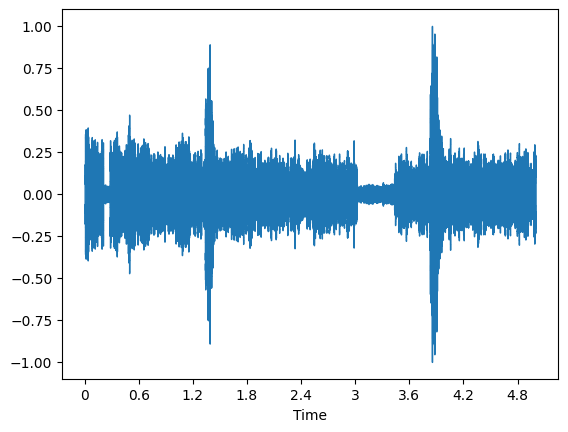

In [ ]:
librosa.display.waveshow(audio_aug, sr=sr)

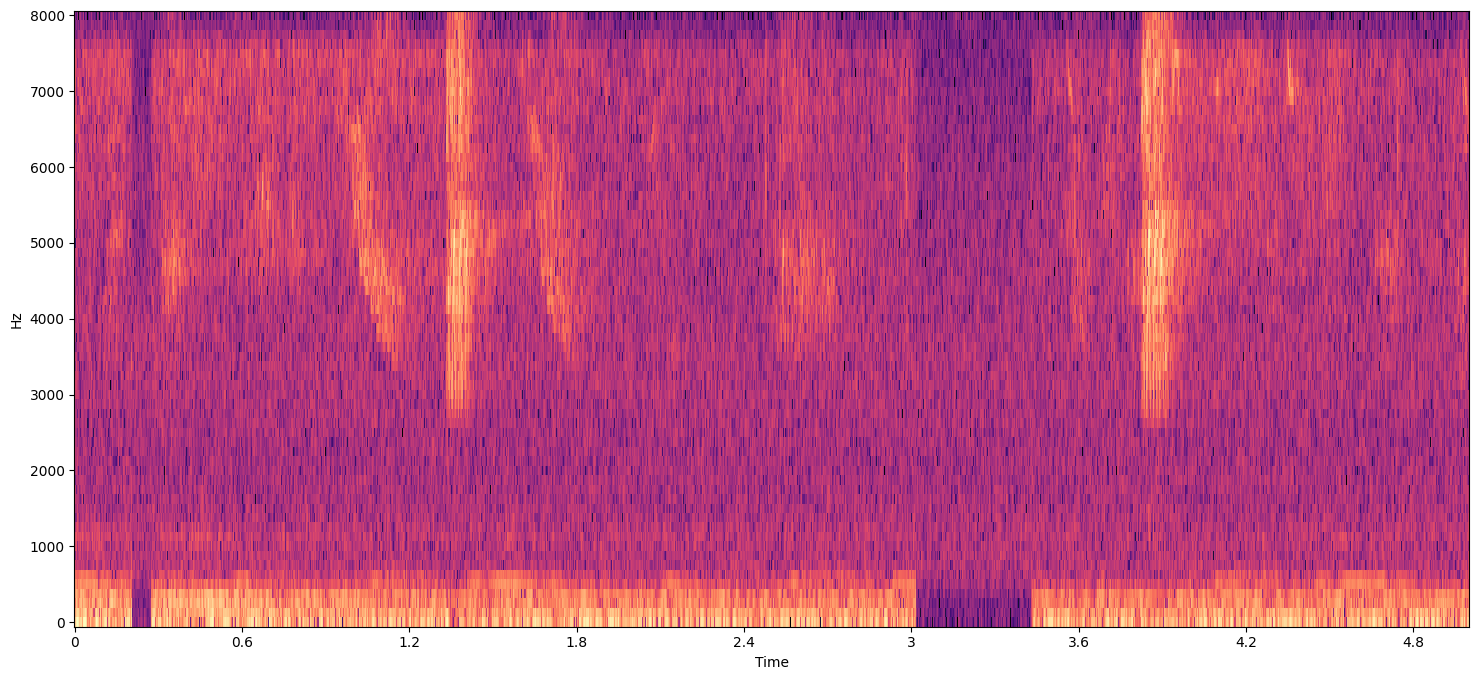

In [ ]:
# S = np.abs(librosa.stft(librosa.mu_compress(audio_clip, mu=127, quantize=False), n_fft=128, hop_length=32))
S = np.abs(librosa.stft(audio_aug, n_fft=128, hop_length=32))
S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(18,8))
librosa.display.specshow(
    S_db
    , x_axis='time'
    , y_axis='linear'
    , sr=sr
    , hop_length=32
)

In [ ]:
# S_med = librosa.decompose.nn_filter(S, aggregate=np.median, axis=0)
# S_med_db = librosa.amplitude_to_db(S_med, ref=np.max)
# plt.figure(figsize=(18,8))
# librosa.display.specshow(
#     S_med_db
#     , x_axis='time'
#     , y_axis='linear'
#     , sr=sr
#     , hop_length=32
# )

In [ ]:
S.shape

(65, 2501)

In [ ]:
print(np.min(S), np.max(S), np.mean(S))
print(np.min(S_db), np.max(S_db), np.mean(S_db))

4.0627248e-07 10.242829 0.25617495
-80.0 0.0 -40.982864


In [ ]:
nmf = NMF(n_components=4, max_iter=500, verbose=0)
# nmf = NMF(n_components=8, max_iter=300, beta_loss='kullback-leibler', solver='mu', verbose=0)
comps, acts = librosa.decompose.decompose(S, transformer=nmf)
# comps, acts = librosa.decompose.decompose(S, n_components=8, sort=True)
print(f'spectrogram: {S.shape}')
print(f'components: {comps.shape}')
print(f'activations: {acts.shape}')
print()
print(f'spectrogram # weights: {len(S.flatten())}')
print(f'decomp # weights: {len(comps.flatten()) + len(acts.flatten())}')

spectrogram: (65, 2501)
components: (65, 4)
activations: (4, 2501)

spectrogram # weights: 162565
decomp # weights: 10264


In [ ]:
np.median(acts)

0.006590308

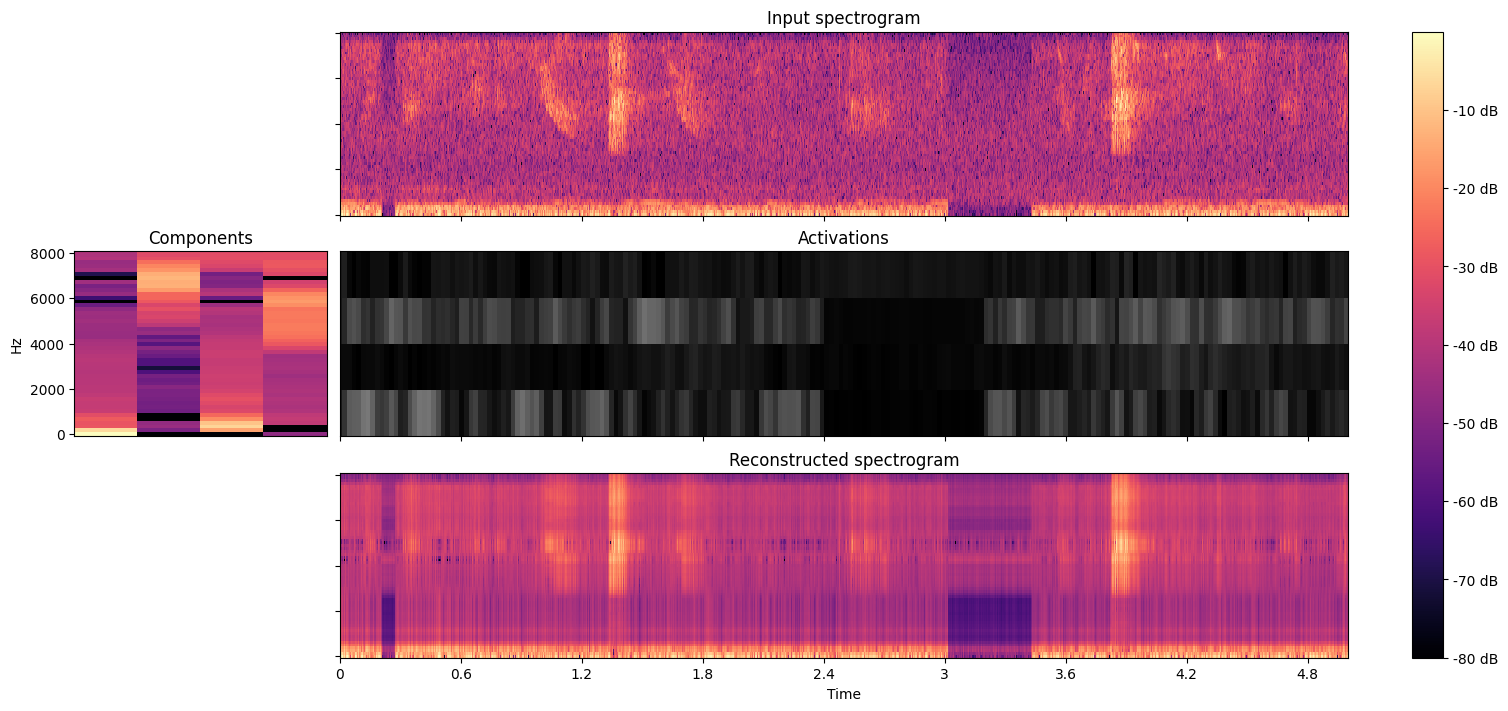

In [ ]:
layout = [list(".AAAA"), list("BCCCC"), list(".DDDD")]
fig, ax = plt.subplot_mosaic(layout, constrained_layout=True, figsize=(15, 7))
librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                         y_axis='linear', x_axis='time', sr=sr, hop_length=32, ax=ax['A'])
ax['A'].set(title='Input spectrogram')
ax['A'].label_outer()
librosa.display.specshow(librosa.amplitude_to_db(comps,
                                                 ref=np.max),
                         y_axis='linear', hop_length=32, ax=ax['B'])
ax['B'].set(title='Components')
ax['B'].label_outer()
ax['B'].sharey(ax['A'])
#librosa.display.specshow(librosa.amplitude_to_db(acts, ref=np.max), x_axis='time', ax=ax['C'], cmap='gray')
librosa.display.specshow(acts ** 0.75, x_axis='time', ax=ax['C'], cmap='gray')
ax['C'].set(ylabel='Components', title='Activations')
ax['C'].sharex(ax['A'])
ax['C'].label_outer()
S_approx = comps.dot(acts)
img = librosa.display.specshow(librosa.amplitude_to_db(S_approx,
                                                       ref=np.max),
                               y_axis='linear', x_axis='time', sr=sr, hop_length=32, ax=ax['D'])
ax['D'].set(title='Reconstructed spectrogram')
ax['D'].sharex(ax['A'])
ax['D'].sharey(ax['A'])
ax['D'].label_outer()
fig.colorbar(img, ax=list(ax.values()), format="%+2.f dB")

In [ ]:
audio_approx = librosa.griffinlim(S_approx, n_iter=256)
audio_approx

array([ 0.00273044,  0.04189423,  0.01047399, ..., -0.01954192,
        0.06151311,  0.04658046], dtype=float32)

In [ ]:
len(audio_approx)

80000

In [ ]:
Audio(audio_approx, rate=sr)

# Prepare train metadata

In [18]:
train_meta_df

primary_label          common_name    scientific_name  species_rank  \
0          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
1          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
2          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
3          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
4          thrnig1   Thrush Nightingale  Luscinia luscinia             0   
...            ...                  ...                ...           ...   
3273       cohmar1  Common House-Martin   Delichon urbicum             9   
3274       cohmar1  Common House-Martin   Delichon urbicum             9   
3275       cohmar1  Common House-Martin   Delichon urbicum             9   
3276       cohmar1  Common House-Martin   Delichon urbicum             9   
3277       cohmar1  Common House-Martin   Delichon urbicum             9   

                  filename dataset  duration_secs  duration_mins  \
0     thrnig1/XC110335.ogg   train     119.275102       1.987918   
1     thrnig1/XC110336.ogg   train     122.044127       2.034069   
2     thrnig1/XC118260.ogg   train      44.382041       0.739701   
3     thrnig1/XC120947.ogg   train     189.231066       3.153851   
4     thrnig1/XC125024.ogg   train      45.312018       0.755200   
...                    ...     ...            ...            ...   
3273  cohmar1/XC748724.ogg   train      54.909025       0.915150   
3274  cohmar1/XC748726.ogg   train       6.974694       0.116245   
3275  cohmar1/XC749483.ogg   train      20.950249       0.349171   
3276  cohmar1/XC749638.ogg   train       6.984036       0.116401   
3277  cohmar1/XC751198.ogg   train      17.266032       0.287767   

      duration_hrs  species_total_files  species_train_files  \
0         0.033132                  499                  349   
1         0.033901                  499                  349   
2         0.012328                  499                  349   
3         0.052564                  499                  349   
4         0.012587                  499                  349   
...            ...                  ...                  ...   
3273      0.015253                  408                  286   
3274      0.001937                  408                  286   
3275      0.005820                  408                  286   
3276      0.001940                  408                  286   
3277      0.004796                  408                  286   

      species_test_files  species_total_duration_hrs  \
0                    150                   17.078735   
1                    150                   17.078735   
2                    150                   17.078735   
3                    150                   17.078735   
4                    150                   17.078735   
...                  ...                         ...   
3273                 122                    5.656965   
3274                 122                    5.656965   
3275                 122                    5.656965   
3276                 122                    5.656965   
3277                 122                    5.656965   

      species_train_duration_hrs  species_test_duration_hrs  total_files  \
0                      10.739077                   6.339658         4680   
1                      10.739077                   6.339658         4680   
2                      10.739077                   6.339658         4680   
3                      10.739077                   6.339658         4680   
4                      10.739077                   6.339658         4680   
...                          ...                        ...          ...   
3273                    4.103189                   1.553775         4680   
3274                    4.103189                   1.553775         4680   
3275                    4.103189                   1.553775         4680   
3276                    4.103189                   1.553775         4680 

In [19]:
train_meta_df.columns

Index(['primary_label', 'common_name', 'scientific_name', 'species_rank',
       'filename', 'dataset', 'duration_secs', 'duration_mins', 'duration_hrs',
       'species_total_files', 'species_train_files', 'species_test_files',
       'species_total_duration_hrs', 'species_train_duration_hrs',
       'species_test_duration_hrs', 'total_files', 'train_files', 'test_files',
       'total_duration_hrs', 'train_duration_hrs', 'test_duration_hrs',
       'filename_npy', 'type', 'secondary_labels', 'rating', 'latitude',
       'longitude', 'author', 'url', 'license', 'class_weight_file',
       'class_weight_duration', 'class_weight_combined', 'orig_index'],
      dtype='object')

In [20]:
train_df = train_meta_df[[
    'species_rank'
    , 'filename'
    , 'duration_secs'
    , 'train_duration_hrs'
]]
train_df

species_rank              filename  duration_secs  train_duration_hrs
0                0  thrnig1/XC110335.ogg     119.275102           49.463144
1                0  thrnig1/XC110336.ogg     122.044127           49.463144
2                0  thrnig1/XC118260.ogg      44.382041           49.463144
3                0  thrnig1/XC120947.ogg     189.231066           49.463144
4                0  thrnig1/XC125024.ogg      45.312018           49.463144
...            ...                   ...            ...                 ...
3273             9  cohmar1/XC748724.ogg      54.909025           49.463144
3274             9  cohmar1/XC748726.ogg       6.974694           49.463144
3275             9  cohmar1/XC749483.ogg      20.950249           49.463144
3276             9  cohmar1/XC749638.ogg       6.984036           49.463144
3277             9  cohmar1/XC751198.ogg      17.266032           49.463144

[3278 rows x 4 columns]

In [21]:
train_df['perc_of_train_hrs'] = train_df['duration_secs'] / ( 60 * 60 * train_df['train_duration_hrs'])
train_df

<ipython-input-21-481eea9b42a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['perc_of_train_hrs'] = train_df['duration_secs'] / ( 60 * 60 * train_df['train_duration_hrs'])


species_rank              filename  duration_secs  train_duration_hrs  \
0                0  thrnig1/XC110335.ogg     119.275102           49.463144   
1                0  thrnig1/XC110336.ogg     122.044127           49.463144   
2                0  thrnig1/XC118260.ogg      44.382041           49.463144   
3                0  thrnig1/XC120947.ogg     189.231066           49.463144   
4                0  thrnig1/XC125024.ogg      45.312018           49.463144   
...            ...                   ...            ...                 ...   
3273             9  cohmar1/XC748724.ogg      54.909025           49.463144   
3274             9  cohmar1/XC748726.ogg       6.974694           49.463144   
3275             9  cohmar1/XC749483.ogg      20.950249           49.463144   
3276             9  cohmar1/XC749638.ogg       6.984036           49.463144   
3277             9  cohmar1/XC751198.ogg      17.266032           49.463144   

      perc_of_train_hrs  
0              0.000670  
1              0.000685  
2              0.000249  
3              0.001063  
4              0.000254  
...                 ...  
3273           0.000308  
3274           0.000039  
3275           0.000118  
3276           0.000039  
3277           0.000097  

[3278 rows x 5 columns]

In [22]:
train_df['filepath'] = train_df['filename'].apply(
    lambda x: gdi.get_sample_path('train_audio', x)
)
train_df

<ipython-input-22-8b0e4bd99b92>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['filepath'] = train_df['filename'].apply(


species_rank              filename  duration_secs  train_duration_hrs  \
0                0  thrnig1/XC110335.ogg     119.275102           49.463144   
1                0  thrnig1/XC110336.ogg     122.044127           49.463144   
2                0  thrnig1/XC118260.ogg      44.382041           49.463144   
3                0  thrnig1/XC120947.ogg     189.231066           49.463144   
4                0  thrnig1/XC125024.ogg      45.312018           49.463144   
...            ...                   ...            ...                 ...   
3273             9  cohmar1/XC748724.ogg      54.909025           49.463144   
3274             9  cohmar1/XC748726.ogg       6.974694           49.463144   
3275             9  cohmar1/XC749483.ogg      20.950249           49.463144   
3276             9  cohmar1/XC749638.ogg       6.984036           49.463144   
3277             9  cohmar1/XC751198.ogg      17.266032           49.463144   

      perc_of_train_hrs  \
0              0.000670   
1              0.000685   
2              0.000249   
3              0.001063   
4              0.000254   
...                 ...   
3273           0.000308   
3274           0.000039   
3275           0.000118   
3276           0.000039   
3277           0.000097   

                                                                            filepath  
0     /content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC110335.ogg  
1     /content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC110336.ogg  
2     /content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC118260.ogg  
3     /content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC120947.ogg  
4     /content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC125024.ogg  
...                                                                              ...  
3273  /content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC748724.ogg  
3274  /content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC748726.ogg  
3275  /content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC749483.ogg  
3276  /content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC749638.ogg  
3277  /content/drive/MyDrive/207-Project/data/train/audio_files/cohmar1/XC751198.ogg  

[3278 rows x 6 columns]

# Define Data Loader

In [23]:
train_idx = np.array(train_df.index)
train_labels = np.array(train_df['species_rank'])
train_filepaths = list(train_df['filepath'])
train_durations = np.array(train_df['duration_secs'])
train_probs = np.array(train_df['perc_of_train_hrs'])

print(train_idx)
print(train_labels)
print(train_filepaths[:2])
print(train_durations)
print(train_probs)

[   0    1    2 ... 3275 3276 3277]
[0 0 0 ... 9 9 9]
['/content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC110335.ogg', '/content/drive/MyDrive/207-Project/data/train/audio_files/thrnig1/XC110336.ogg']
[119.27510204 122.04412698  44.38204082 ...  20.95024943   6.98403628
  17.26603175]
[6.69831519e-04 6.85381958e-04 2.49243047e-04 ... 1.17653535e-04
 3.92213258e-05 9.69635077e-05]


In [24]:
augment_audio = am.Compose([
    am.Normalize(p=1.0)
    , am.OneOf([
        am.Lambda(transform=audio_compress, mu_min=1, mu_max=17, p=0.65)
        , am.Lambda(transform=audio_expand, mu_min=1, mu_max=17, p=0.65)
    ])
    , am.SevenBandParametricEQ(min_gain_db=-12.0, max_gain_db=12.0, p=0.5)
    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_silent_frames, p=0.25)
    # , am.TimeMask(0.1, 0.2, p=0.5)
    # , am.TimeMask(0.05, 0.1, p=0.5)
    # , am.TimeMask(0.025, 0.05, p=0.5)
    # , am.TimeMask(0.01, 0.02, p=0.5)
    # , am.TimeMask(0.01, 0.02, p=0.5)
    # , am.TimeMask(0.01, 0.02, p=0.5)
    , am.Lambda(
        transform=add_colored_noise2
        , min_gain_db=-12.0
        , max_gain_db=12.0
        , scale_min=0.005
        , scale_max=0.05
        , p=0.5
    )
    , am.Normalize(p=1.0)
    , am.Lambda(transform=add_crackle, p=0.25)
])

In [25]:
def audio_generator(idx
                    , labels
                    , filepaths
                    , durations
                    , files_per_batch=8
                    , batch_size=64
                    , prob_smoothing=0.0
                    , clip_length=5.0
                    , target_sr=16000
                    , n_fft=128
                    , hop_length=32
                    , augment=False
                    ):
  clip_samples = int(clip_length * target_sr)
  spec_fdim = n_fft // 2 + 1
  spec_tdim = clip_samples // hop_length + 1

  ch_idx = np.random.choice(idx, size=files_per_batch)
  ch_labels = labels[ch_idx]
  ch_paths = [filepaths[i] for i in ch_idx]
  ch_durs = durations[ch_idx]
  ch_probs = ch_durs / np.sum(ch_durs)
  if prob_smoothing != 0.0:
    unif_probs = np.ones_like(ch_probs) / float(files_per_batch)
    ch_probs = (prob_smoothing * unif_probs) + ((1.0 - prob_smoothing) * ch_probs)

  # print(ch_idx)
  # print(ch_labels)
  # for path in ch_paths:
  #   print(path)
  # print(ch_durs)
  # print(ch_probs)
  # print(np.sum(ch_probs))

  jdx = np.arange(files_per_batch)
  batch_jdx = np.random.choice(jdx, size=batch_size, p=ch_probs)
  batch_labels = np.zeros((batch_size, ), dtype=np.uint8)
  batch_audio = np.zeros((batch_size, clip_samples), dtype=np.float32)
  batch_spec = np.zeros((batch_size, spec_fdim, spec_tdim), dtype=np.float32)
  for j in range(batch_size):
    sel_jdx = batch_jdx[j]
    batch_labels[j] = ch_labels[sel_jdx]
    audio, sr, _ = load_random_clip(
        file_path = ch_paths[sel_jdx]
        , file_duration = ch_durs[sel_jdx]
        , clip_secs=clip_length
    )
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    if augment:
      audio = augment_audio(audio, target_sr)
    # audio_aug = augment_audio(audio_resampled, sr)
    batch_audio[j,:] = audio
    spec = np.abs(librosa.stft(audio, n_fft=n_fft, hop_length=hop_length))

    # batch_spec[j,:,:] = spec

    spec_db = librosa.amplitude_to_db(spec, ref=np.max)
    #spec_db_sc = spec_db
    #spec_db_sc = (spec_db + 80.0) / 80.0
    spec_db_sc = spec_db - np.repeat(np.mean(spec_db, axis=1).reshape(-1,1), spec_tdim, axis=1)
    spec_db_sc -= np.mean(spec_db_sc)
    spec_db_sc /= np.std(spec_db_sc)
    batch_spec[j,:,:] = spec_db_sc

  return batch_labels, batch_audio, batch_spec


In [137]:
sample_labels, sample_audios, sample_specs = audio_generator(
    train_idx
    , train_labels
    , train_filepaths
    , train_durations
    , files_per_batch=8
    , batch_size=64
    , prob_smoothing=0.5
    , clip_length=5.0
    , target_sr=16000
    , n_fft=128
    , hop_length=32
    , augment=True
    )

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


In [138]:
sample_specs.shape

(64, 65, 2501)

In [532]:
# np.save(gdi.join_to_shared('data/test_feature_out'), specs)

In [139]:
batch_item = 0
sample_label = sample_labels[batch_item]
sample_audio = sample_audios[batch_item,:]
sample_spec = sample_specs[batch_item, :, :]
Audio(sample_audio, rate=16000, autoplay=True)

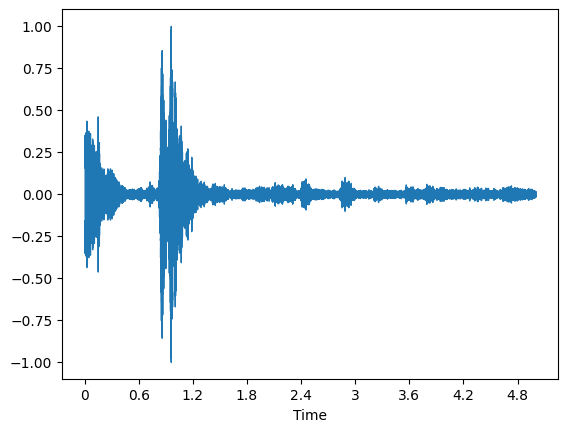

In [140]:
librosa.display.waveshow(sample_audio, sr=16000)

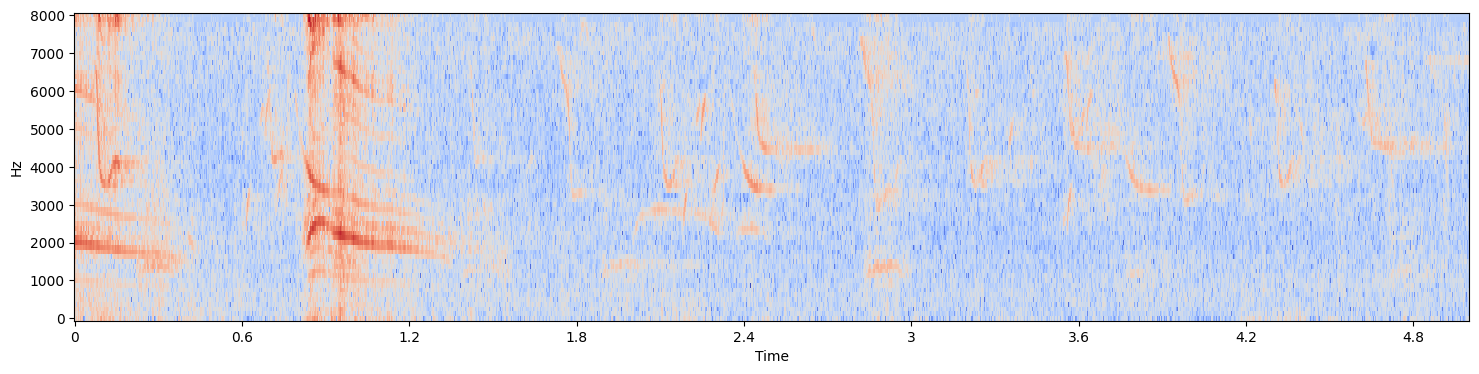

In [141]:
# S = np.abs(librosa.stft(sample_audio, n_fft=128, hop_length=32))
# S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(18,4))
librosa.display.specshow(
    sample_spec
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=32
)

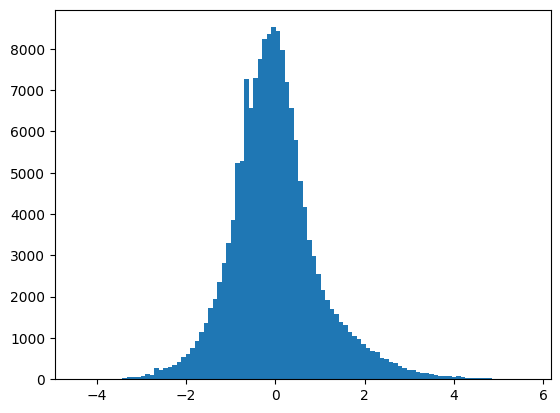

In [142]:
plt.hist(sample_spec.flatten(), bins=100)
plt.show()

# Additional exploration

In [80]:
S_db_rs = sample_spec - np.repeat(np.mean(sample_spec, axis=1).reshape(-1,1), 2501, axis=1)
S_db_rs -= np.mean(S_db_rs)
S_db_rs /= np.std(S_db_rs)

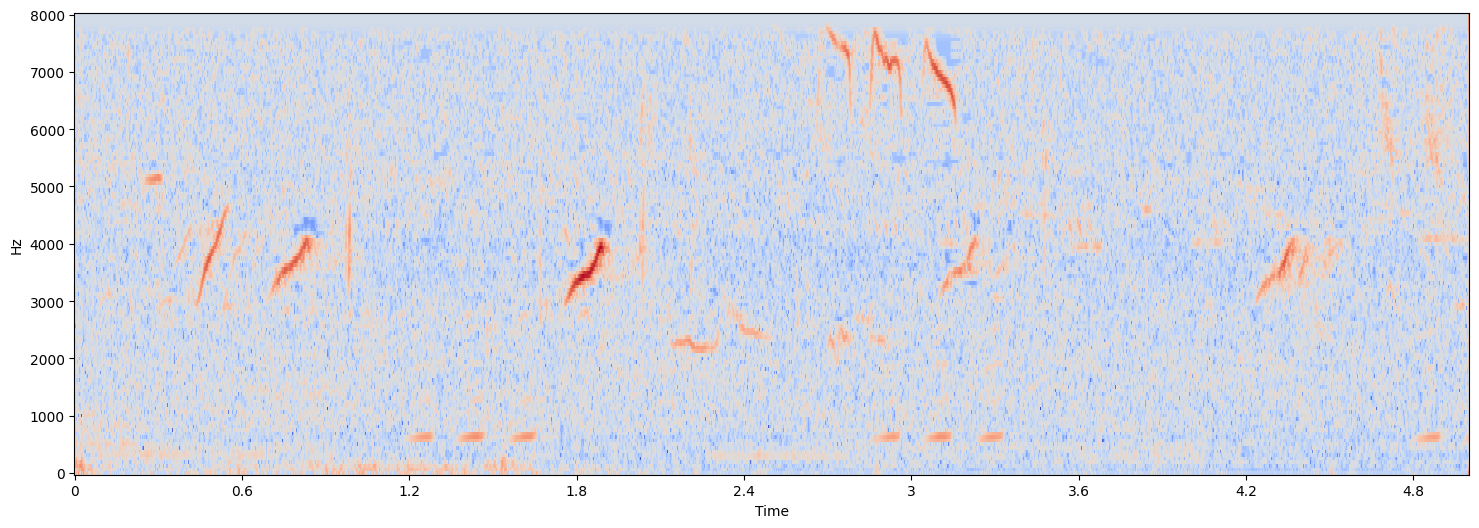

In [81]:
# S = np.abs(librosa.stft(sample_audio, n_fft=128, hop_length=32))
# S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(18,6))
librosa.display.specshow(
    S_db_rs
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=32
)

In [83]:
np.min(S_db_rs)

-6.1136584

In [49]:
np.repeat(np.median(sample_spec, axis=1).reshape(-1,1), 2501, axis=1)

array([[0.3346191 , 0.3346191 , 0.3346191 , ..., 0.3346191 , 0.3346191 ,
        0.3346191 ],
       [0.28522387, 0.28522387, 0.28522387, ..., 0.28522387, 0.28522387,
        0.28522387],
       [0.24101314, 0.24101314, 0.24101314, ..., 0.24101314, 0.24101314,
        0.24101314],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

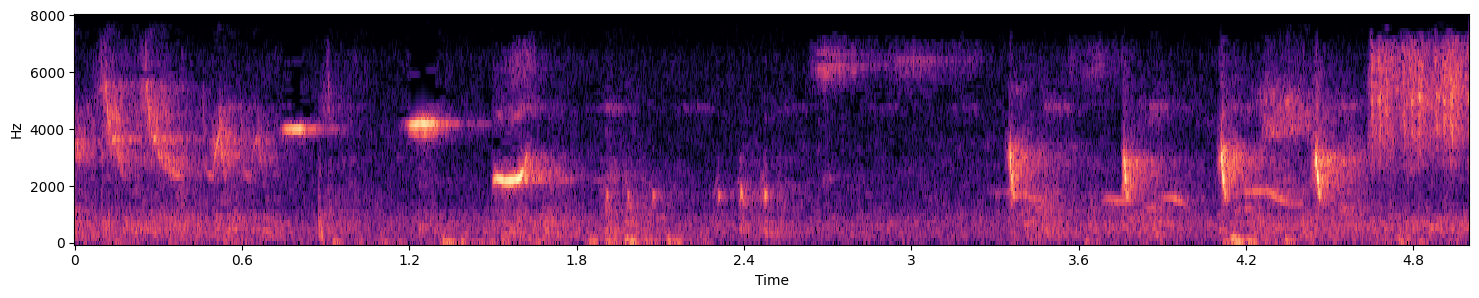

In [222]:
D = librosa.stft(sample_audio, n_fft=128, hop_length=32)
S, P = librosa.magphase(D, power=1)
S_db = librosa.amplitude_to_db(
    S=S
    ,amin=0.00001
    ,ref=np.max
)
# S_angle = np.angle(S)
plt.figure(figsize=(18,3))
librosa.display.specshow(
    S_db
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=32
)

In [76]:
S_db.shape

(65, 2501)

In [119]:
sample_rms = librosa.feature.rms(
    S=S
)
sample_rms
plt.plot(sample_rms.T)

ParameterError: ignored

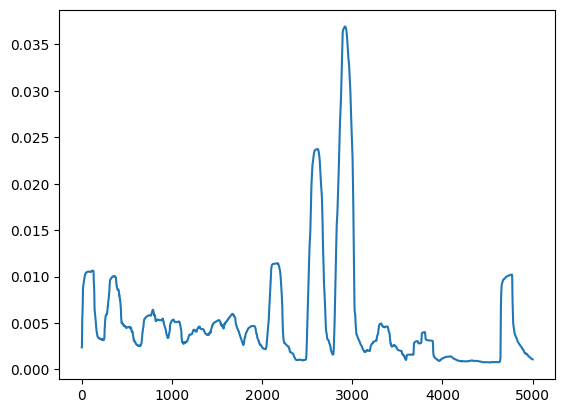

In [205]:
sample_rms = librosa.feature.rms(
    y=sample_audio
    ,frame_length=2048
    ,hop_length=16
    ,pad_mode='edge'
)
sample_rms
plt.plot(sample_rms.T)

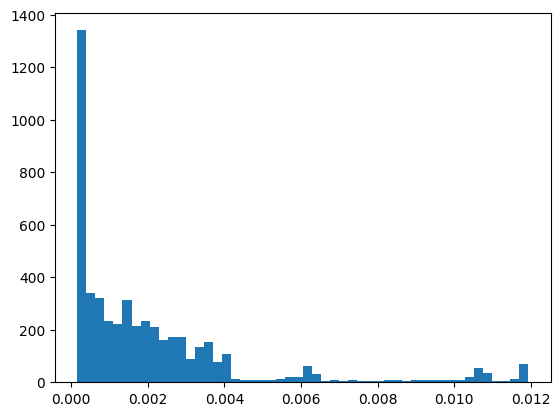

In [169]:
plt.hist(sample_rms.T, bins=50)
plt.show()

In [206]:
min_rms_frame = np.argmin(sample_rms)
min_rms_frame

4531

In [207]:
min_rms_sample_loc = librosa.frames_to_samples(min_rms_frame, hop_length=16)
min_rms_sample_locs = (min_rms_sample_loc - 1024, min_rms_sample_loc + 1024)
min_rms_frames = librosa.samples_to_frames(samples=min_rms_sample_locs, hop_length=16)
min_rms_frames

array([4467, 4595])

In [208]:
plt.figure(figsize=(6,6))
librosa.display.specshow(
    S_db[:,min_rms_frames[0]:min_rms_frames[1]]
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=16
)

IndexError: ignored

<Figure size 600x600 with 0 Axes>

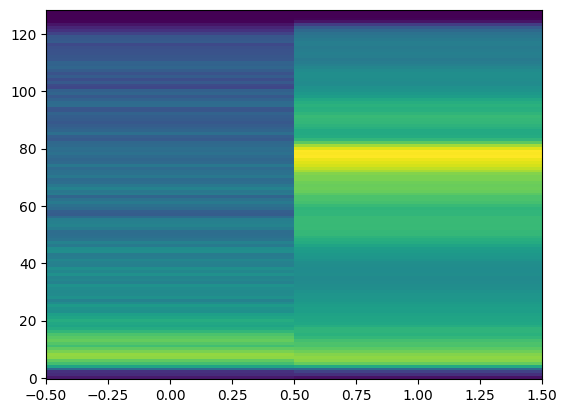

In [210]:
min_rms_freq_means = np.mean(S_db[:,min_rms_frames[0]:min_rms_frames[1]], axis=1)
all_freq_means = np.mean(S_db, axis=1)
freq_means = np.stack([min_rms_freq_means, all_freq_means])
plt.imshow(freq_means.T, aspect='auto', origin='lower', interpolation='none')

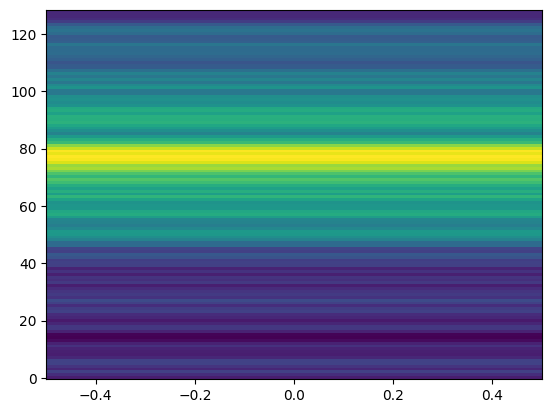

In [212]:
freq_mean_ratio = all_freq_means-min_rms_freq_means
freq_mean_ratio
plt.imshow(np.expand_dims(freq_mean_ratio, axis=1), aspect='auto', origin='lower', interpolation='none')

In [232]:
S_db_nr = S_db - np.repeat(min_rms_freq_means.reshape(-1,1), repeats=5001, axis=1)
S_db_nr_min, S_db_nr_max = np.min(S_db_nr), np.max(S_db_nr)
S_db_nr_range = S_db_nr_max - S_db_nr_min
S_db_nr_sc = (S_db_nr - S_db_nr_min)*(80.0/S_db_nr_range)-80
print(S_db_nr_min, S_db_nr_max, S_db_nr_range)

-30.357292 66.105286 96.46258


In [234]:
print(np.min(S_db), np.min(S_db_nr), np.min(S_db_nr_sc))
print(np.max(S_db), np.max(S_db_nr), np.max(S_db_nr_sc))

-80.0 -30.357292 -80.0
0.0 66.105286 0.0


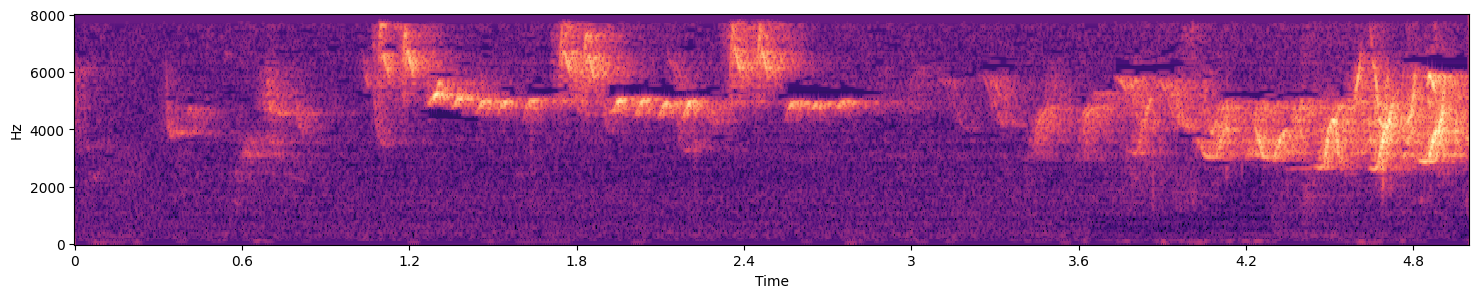

In [235]:
plt.figure(figsize=(18,3))
librosa.display.specshow(
    S_db_nr_sc
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=16
)

In [ ]:
S_noise_rescaled = all_freq_means/min_rms_freq_means
freq_mean_ratio
# plt.imshow(np.expand_dims(freq_mean_ratio, axis=1), aspect='auto', origin='lower', interpolation='none')

In [130]:
D.shape

(129, 5001)

In [ ]:
S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(18,6))
librosa.display.specshow(
    S_db
    , x_axis='time'
    , y_axis='linear'
    , sr=16000
    , hop_length=16
)

In [ ]:
plt.imshow(sample_spec[10:30, 1450:1500], origin='lower')
#plt.imshow(sample_spec, origin='lower')

# Model-building

In [174]:
inputs = tf.keras.Input(shape=(65, 2501))

# crop1 = layers.Cropping1D(
#     cropping=(1,0)
# )(inputs)

permute1 = layers.Permute((2,1))(inputs)

# conv1d_k1 = layers.Conv1D(
#     filters=64
#     ,kernel_size=1
#     ,strides=1
#     ,groups=64
#     ,padding='valid'
#     ,kernel_initializer='ones'
#     ,bias_initializer='zeros'
# )(permute1)
# conv1d_k1_relu = layers.ReLU(max_value=1.0)(conv1d_k1)

lstm_fwd = layers.LSTM(
    units=16
    ,return_sequences=True
)

lstm_bwd = layers.LSTM(
    units=16
    ,return_sequences=True
    ,go_backwards=True
)
# Reverse = layers.Lambda(
#     lambda x: tf.keras.backend.reverse(x, axes=1)
#     ,output_shape=(None, 2501, 32)
# )
# lstm_bwd_rv = Reverse(lstm_bwd)

#lstm_bi = layers.Concatenate(axis=-1)([lstm_fwd, lstm_bwd])
lstm_bi = layers.Bidirectional(
    layer=lstm_fwd
    , backward_layer=lstm_bwd
)(permute1)

# dense1 = layers.Dense(
#     units=32
#     ,activation='relu'
# )(lstm_bi)
# dense1_do = layers.Dropout(
#     rate = 0.1
#     , noise_shape=(None,1,32)
# )(dense1, training=True)

dense1 = layers.Dense(
    units=10
)(lstm_bi)

preds1 = layers.GlobalAveragePooling1D()(dense1)

dense2 = layers.Dense(
    units=65
    ,bias_initializer=tf.keras.initializers.zeros
)(dense1)
dense2_sm = layers.Softmax()(dense2)

# mask_dense = layers.Dense(
#     units=1
# )(lstm_bi)
# mask_dense_sm = layers.Softmax(axis=-2)(mask_dense)

# masked_dense = layers.Dot(axes=(1,1))([dense, mask_dense_sm])
# preds = layers.Flatten()(masked_dense)

# lstm_fwd_m = tf.keras.Model(inputs, lstm_fwd)
# lstm_bwd_m = tf.keras.Model(inputs, lstm_bwd)
#lstm_bwd_rv_m = tf.keras.Model(inputs, lstm_bwd_rv)
lstm_bi_m = tf.keras.Model(inputs, lstm_bi)
#lstm_bi_do_m = tf.keras.Model(inputs, lstm_bi_do)
# lstm_avg_m = tf.keras.Model(inputs, lstm_avg)
#dense1_m = tf.keras.Model(inputs, dense1)
# lstm_bi_ln_m = tf.keras.Model(inputs, lstm_bi_ln)
# lstm_bi_ln_relu_m = tf.keras.Model(inputs, lstm_bi_ln_relu)
dense1_m = tf.keras.Model(inputs, dense1)
dense2_m = tf.keras.Model(inputs, dense2)
dense2_sm_m = tf.keras.Model(inputs, dense2_sm)
# mask_dense_m = tf.keras.Model(inputs, mask_dense)
# mask_dense_sm_m = tf.keras.Model(inputs, mask_dense_sm)
# masked_dense_m = tf.keras.Model(inputs, masked_dense)
model = tf.keras.Model(inputs, preds1)
model.summary()

# model.build(input_shape=(None, 129, 5001))
# model.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 65, 2501)]        0         
                                                                 
 permute_8 (Permute)         (None, 2501, 65)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 2501, 32)         10496     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 2501, 10)          330       
                                                                 
 global_average_pooling1d_8   (None, 10)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 10,826
Trainable params: 10,826
Non-trainabl

In [175]:
dense2_sm_m.summary()

Model: "model_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 65, 2501)]        0         
                                                                 
 permute_8 (Permute)         (None, 2501, 65)          0         
                                                                 
 bidirectional_6 (Bidirectio  (None, 2501, 32)         10496     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 2501, 10)          330       
                                                                 
 dense_15 (Dense)            (None, 2501, 65)          715       
                                                                 
 softmax_1 (Softmax)         (None, 2501, 65)          0         
                                                          

In [481]:
# sample_spec_reshape = specs[batch_item, :, :, 0].T.reshape((1,2501,65))
# sample_spec_reshape.shape

(1, 2501, 65)

In [272]:
np.array(model.get_layer('conv_4').get_weights()[0]).shape

(1, 1, 64, 16)

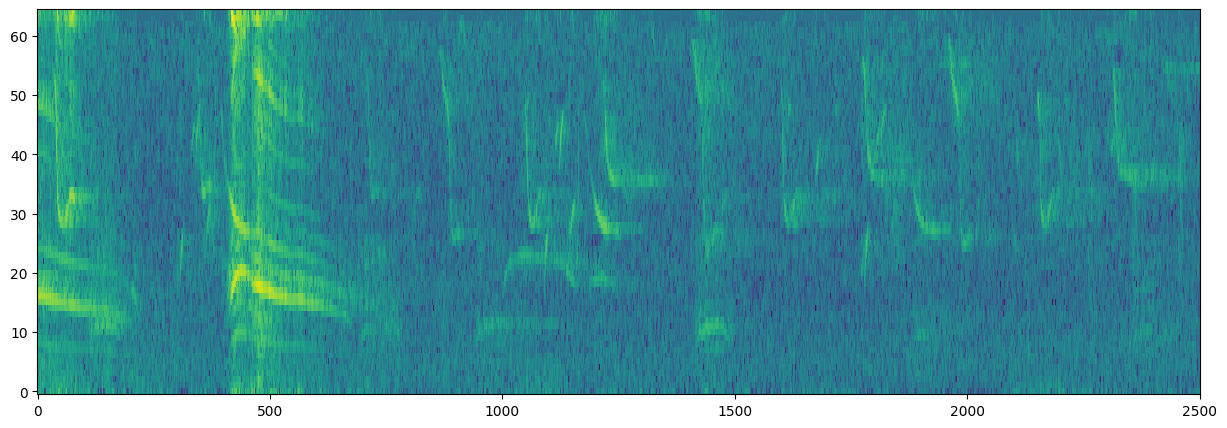

In [143]:
plt.figure(figsize=(15,5))
plt.imshow(sample_spec, aspect='auto', origin='lower', interpolation='none')

In [ ]:
# sample_spec_filt_f = librosa.decompose.nn_filter(sample_spec, aggregate=np.median)
# sample_spec_filt_t = librosa.decompose.nn_filter(sample_spec, aggregate=np.median, axis=0)
filt_thres = -1.0
sample_spec_filt = (sample_spec > filt_thres) * (sample_spec - filt_thres)
plt.figure(figsize=(15,5))
plt.imshow(sample_spec_filt, aspect='auto', origin='lower', interpolation='none')

In [ ]:
plt.hist(sample_spec_filt.flatten(), bins=100)
plt.show()

In [144]:
resc_input = lstm_bi_m(np.expand_dims(sample_spec, axis=0))
resc_input_sqz = np.array(tf.squeeze(resc_input))
resc_input_sqz

array([[ 1.1059174e-03,  1.8907747e-07, -5.8496559e-01, ...,
         3.8344699e-01, -9.9652177e-01,  3.5401818e-03],
       [ 1.3384060e-03,  2.9728112e-08, -7.4669665e-01, ...,
         6.3755524e-01, -9.9465805e-01,  3.3692572e-02],
       [ 7.6555816e-04,  3.0343284e-07, -6.2202299e-01, ...,
         5.8550990e-01, -9.8587912e-01,  1.7926145e-02],
       ...,
       [-9.5086789e-01, -9.9933869e-01,  8.9380574e-01, ...,
        -4.9974561e-01,  7.0428886e-02, -2.0262273e-01],
       [-8.4237814e-01, -9.9918640e-01,  4.7927344e-01, ...,
        -2.0783205e-01,  8.2665220e-02, -4.9262094e-01],
       [-9.6062732e-01, -9.9974823e-01,  3.8485914e-01, ...,
        -9.6829034e-02,  3.8272101e-02, -4.0683141e-01]], dtype=float32)

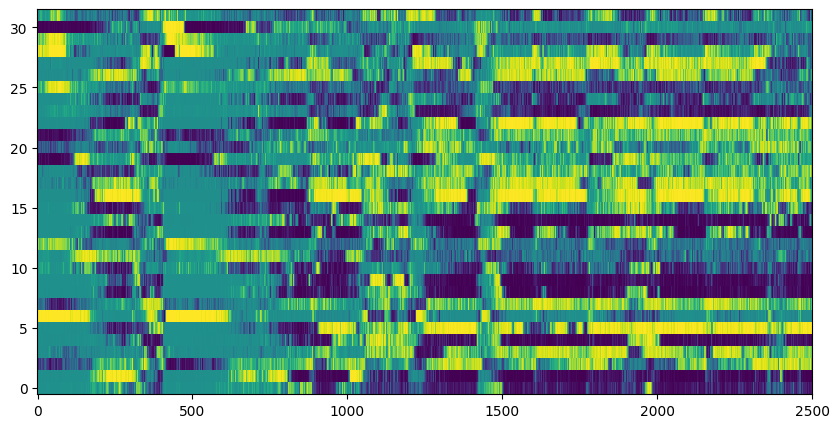

In [145]:
plt.figure(figsize=(10,5))
plt.imshow(resc_input_sqz.T, aspect='auto', origin='lower', interpolation='none')

In [176]:
conv1_out = dense2_sm_m(np.expand_dims(sample_spec, axis=0))
conv1_out

<tf.Tensor: shape=(1, 2501, 65), dtype=float32, numpy=
array([[[0.01754553, 0.01584815, 0.01797629, ..., 0.01503715,
         0.01219157, 0.01353925],
        [0.01897334, 0.0160195 , 0.01638007, ..., 0.01471025,
         0.01126573, 0.01343548],
        [0.01820373, 0.01625167, 0.01577969, ..., 0.01486236,
         0.0112218 , 0.01312856],
        ...,
        [0.01116715, 0.01143502, 0.0148288 , ..., 0.01445512,
         0.01935151, 0.02389802],
        [0.01223779, 0.01143146, 0.01372608, ..., 0.01516325,
         0.01966491, 0.02376782],
        [0.01112609, 0.01220994, 0.01598573, ..., 0.01325591,
         0.02001077, 0.02448973]]], dtype=float32)>

In [177]:
conv1_sqz = np.array(tf.squeeze(conv1_out))
conv1_sqz.shape

(2501, 65)

In [179]:
np.max(conv1_sqz)

0.044549417

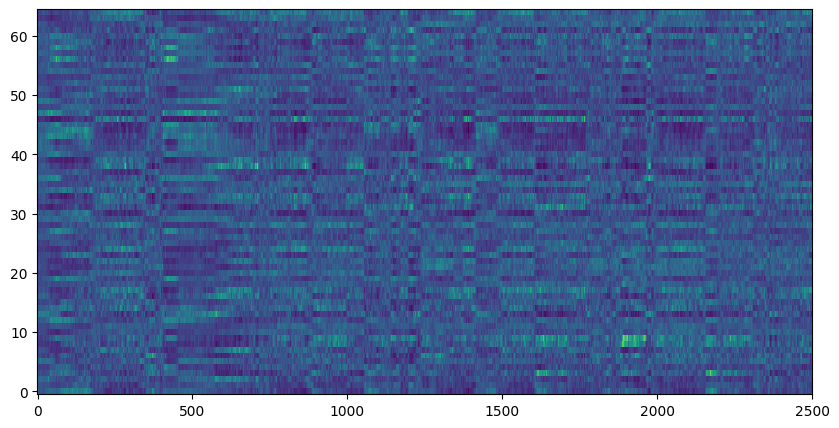

In [180]:
plt.figure(figsize=(10,5))
plt.imshow(conv1_sqz.T, aspect='auto', origin='lower', interpolation='none')

In [149]:
sample_label

6

In [150]:
preds = model(np.expand_dims(sample_spec, axis=0))
preds_sqz = np.array(tf.squeeze(preds))
preds_sqz

array([ 1.9168321 , -0.71782166, -1.2824025 , -1.5566344 , -0.76435935,
       -0.92899644,  1.3693187 ,  0.0282766 ,  0.93226194, -0.86242825],
      dtype=float32)

In [151]:
loss_fn([sample_label], preds)

<tf.Tensor: shape=(), dtype=float32, numpy=1.4376552>

In [152]:
# sm = tf.keras.layers.Softmax()
sm(preds)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.41059753, 0.02945783, 0.01674968, 0.01273236, 0.02811834,
        0.02385002, 0.23748396, 0.06211938, 0.15339915, 0.0254917 ]],
      dtype=float32)>

In [ ]:
plt.figure(figsize=(6,2))
plt.imshow(np.array(sm(conv1_out)), aspect='auto', origin='lower', interpolation='none')

In [ ]:
filter_num = 3
conv1_filter = conv1_sqz[:,:,filter_num]
plt.figure(figsize=(15,5))
plt.imshow(conv1_filter.T, aspect='auto', origin='lower', interpolation='none')

In [ ]:
check_output = model(specs)
check_output

In [56]:
#optimizer = tf.keras.optimizers.SGD(learning_rate=5e-4)
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
losses = []

In [60]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
#optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=5e-3)

In [121]:
epochs=20

for epoch in range(epochs):
  labels, _, specs = audio_generator(
      train_idx
      , train_labels
      , train_filepaths
      , train_durations
      , files_per_batch=16
      , batch_size=64
      , prob_smoothing = 0.5
      , clip_length=5.0
      , target_sr=16000
      , n_fft=128
      , hop_length=32
      , augment=True
      )
  with tf.GradientTape() as tape:
    logits = model(specs, training=True)
    loss_value = loss_fn(labels, logits)

  losses.append(float(loss_value))
  grads = tape.gradient(loss_value, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))

  if epoch % 1 == 0:
    print(f'Batch {epoch} loss: {float(loss_value):.4f}')

/usr/local/lib/python3.10/dist-packages/audiomentations/core/transforms_interface.py:61: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(


Batch 0 loss: 2.0217
Batch 1 loss: 1.8305
Batch 2 loss: 1.9695
Batch 3 loss: 1.9217
Batch 4 loss: 2.0571
Batch 5 loss: 1.8845
Batch 6 loss: 1.5149
Batch 7 loss: 2.1848
Batch 8 loss: 1.9334
Batch 9 loss: 1.8843
Batch 10 loss: 1.9744
Batch 11 loss: 1.8200
Batch 12 loss: 1.8354
Batch 13 loss: 1.8960
Batch 14 loss: 1.7534
Batch 15 loss: 1.8561
Batch 16 loss: 1.6016
Batch 17 loss: 1.5409
Batch 18 loss: 1.6807
Batch 19 loss: 1.9699


<Axes: >

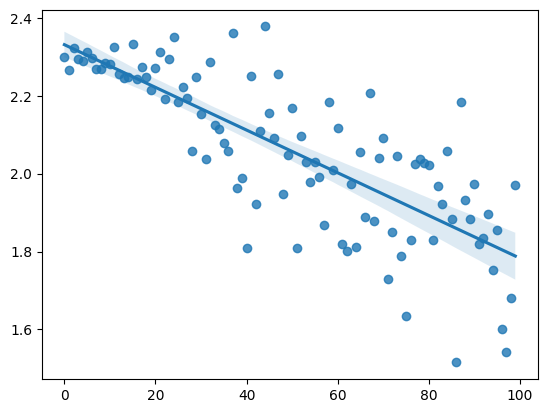

In [122]:
sns.regplot(x=np.arange(len(losses)), y=losses)

In [237]:
model.save(gdi.join_to_shared('models/lstm_bidir_v2_loeber'))

In [99]:
model = tf.keras.models.load_model(gdi.join_to_shared('models/lstm_bidir_loeber'))

In [100]:
model.compile()

In [104]:
model.layers